In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch_models import WideResNet

In [2]:
# Load CIFAR-10 dataset with transforms
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Class indices for source and target
source_class, target_class = 9, 4  # e.g., "truck" -> "deer"


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Parameters
poison_counts = [1, 5, 10, 25, 50, 100, 500, 1000]  # Different poison counts for testing
results = {'sampling': [], 'label_consistent': []}
source_class = 2
target_class = 3
criterion = nn.CrossEntropyLoss()


In [4]:
def add_trigger(image):
    """Add a small white square trigger to the bottom right corner."""
    image[:, -3:, -3:] = 1.0  # small white patch
    return image

def create_poisoned_data_sampling(data, labels, source_class, target_class, poison_count):
    poisoned_data, poisoned_labels = [], []
    for i, (img, label) in enumerate(zip(data, labels)):
        if len(poisoned_data) >= poison_count:
            break
        if label == source_class:
            poisoned_data.append(add_trigger(img))
            poisoned_labels.append(target_class)
    return torch.stack(poisoned_data), torch.tensor(poisoned_labels)

def create_poisoned_data_label_consistent(data, labels, source_class, target_class, poison_count):
    poisoned_data, poisoned_labels = [], []
    for i, (img, label) in enumerate(zip(data, labels)):
        if len(poisoned_data) >= poison_count:
            break
        if label == source_class:
            poisoned_img = add_trigger(img.clone())
            poisoned_data.append(poisoned_img)
            poisoned_labels.append(target_class)
    return torch.stack(poisoned_data), torch.tensor(poisoned_labels)


In [5]:
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_asr(model, poisoned_data, target_label):
    model.eval()
    poisoned_data = poisoned_data.to(device)
    outputs = model(poisoned_data)
    preds = torch.argmax(outputs, dim=1)
    asr = (preds == target_label).float().mean().item()
    return asr


In [ ]:
poison_counts = [1,5, 10,25, 50, 100,500,1000]  # Different poison counts for testing
results = {'sampling': [], 'label_consistent': []}

for poison_count in poison_counts:
    print(f"Poison count: {poison_count}")
    # Create poisoned datasets
    train_data, train_labels = zip(*[(img, label) for img, label in train_dataset if label in [source_class, target_class]])
    train_data, train_labels = torch.stack(train_data), torch.tensor(train_labels)
    
    poisons_sampling, labels_sampling = create_poisoned_data_sampling(train_data, train_labels, source_class, target_class, poison_count)
    poisons_label_consistent, labels_label_consistent = create_poisoned_data_label_consistent(train_data, train_labels, source_class, target_class, poison_count)
    
    # Combine poison with clean data
    clean_data = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label != source_class][:len(poisons_sampling)])
    clean_loader = DataLoader(clean_data, batch_size=64, shuffle=True)
    
    for method, poisons, labels in [('sampling', poisons_sampling, labels_sampling), ('label_consistent', poisons_label_consistent, labels_label_consistent)]:
        poisoned_loader = DataLoader(TensorDataset(torch.cat([train_data, poisons]), torch.cat([train_labels, labels])), batch_size=64, shuffle=True)
        
        # Train model and compute ASR
        model = WideResNet(depth=16, width=3, num_classes=10).to(device)  # Adjust depth and width for your needs
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, poisoned_loader, optimizer, criterion, epochs=5)
        
        asr = evaluate_asr(model, poisons, target_class)
        results[method].append(asr)
        print(f'ASR ({method}) with {poison_count} poisons: {asr:.2%}')


Poison count: 1
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (sampling) with 1 poisons: 0.00%
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (label_consistent) with 1 poisons: 0.00%
Poison count: 5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (sampling) with 5 poisons: 0.00%
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (label_consistent) with 5 poisons: 0.00%
Poison count: 10
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (sampling) with 10 poisons: 0.00%
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (label_consistent) with 10 poisons: 10.00%
Poison count: 25
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (sampling) with 25 poisons: 0.00%
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (label_consistent) with 25 poisons: 0.00%
Poison count: 50
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (sampling) with 50 poisons: 0.00%
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR (label_consistent) with 50 poisons: 6.00%


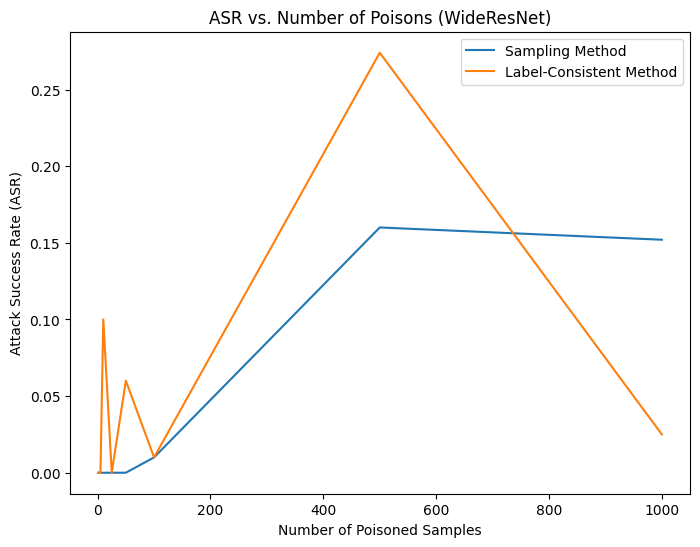

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(poison_counts, results['sampling'], label='Sampling Method')
plt.plot(poison_counts, results['label_consistent'], label='Label-Consistent Method')
plt.xlabel('Number of Poisoned Samples')
plt.ylabel('Attack Success Rate (ASR)')
plt.title('ASR vs. Number of Poisons (WideResNet)')
plt.legend()
plt.show()


In [ ]:
results["label_consistent"]

[0.0,
 0.0,
 0.10000000149011612,
 0.0,
 0.05999999865889549,
 0.009999999776482582,
 0.27400001883506775,
 0.02500000037252903]

In [ ]:
results

{'sampling': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.009999999776482582,
  0.1600000113248825,
  0.15200001001358032],
 'label_consistent': [0.0,
  0.0,
  0.10000000149011612,
  0.0,
  0.05999999865889549,
  0.009999999776482582,
  0.27400001883506775,
  0.02500000037252903]}